## Fiducial cut for one .root file.

In [76]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt

In [62]:
class XCalHitsDataset:
    
    # Parameters specific to your setup
    scoringPlaneZ = 239.9985
    ecalFaceZ = 247.932
    cell_radius = 5.0
    fiducial_mode = True
    
    def __init__(self, fp, load_range=(0,1)):
        super(XCalHitsDataset, self).__init__()
        self._load_cellMap()
        
        self.event_list = []  # == [[mass, filename, i_file], ...]
        
        tfile = r.TFile(fp)
        self.ttree = tfile.Get('skimmed_events')
        print(self.ttree)
        ttree = self.ttree
        print(ttree)
        f_events = self.ttree.GetEntries()  # Num events in file
        # load_range specifies fraction of file to load from.
        start, stop = [int(x * f_events) for x in load_range]
        
        f_event = start
        fiducial_counter = 0
        while f_event < stop:
            # append fiducial check flags for each loaded event
            if self.fiducial_mode and self._compute_fiducial_cut(f_event):
                # skip fiducial events
                f_event += 1
                fiducial_counter += 1
            else: 
                self.event_list.append(f_event)
                f_event += 1
        print('complete init')
        print('calc projs now')
        self._nonFid_projs() 
    
    
    def _load_cellMap(self, version='v14'):
        self._cellMap = {}  # cellMap used for v12 only
        if version=='v12':
            for i, x, y in np.loadtxt('/home/j3lly/LDMX-scripts/GraphNet/data/%s/cellmodule.txt' % version):
                self._cellMap[i] = (x, y)
            self._layerZs = np.loadtxt('/home/j3lly/LDMX-scripts/GraphNet/data/%s/layer.txt' % version)
        if version=='v13' or version=='v14':
            zd = np.loadtxt('/home/j3lly/LDMX-scripts/GraphNet/data/%s/layer.txt' % version)
            self._layerZs = {round(zd[i]):i for i in range(len(zd))}
        if self.fiducial_mode: # need cellMap for v14 non-fiducial study
            for i, x, y in np.loadtxt('/home/j3lly/LDMX-scripts/GraphNet/data/%s/cellmodule.txt' % version):
                self._cellMap[i] = (x, y)
            self._cells = np.array(list(self._cellMap.values()))
        print("Loaded geometry info")
        
    # Calculate projection for fiducial test
    def _projection(self, Recoilx, Recoily, Recoilz, RPx, RPy, RPz, HitZ):
        x_final = Recoilx + RPx/RPz*(HitZ - Recoilz) if RPz != 0 else 0
        y_final = Recoily + RPy/RPz*(HitZ - Recoilz) if RPy != 0 else 0
        return (x_final, y_final)
    
    # Calculate 2D Euclidean distance between cell center and hit
    def _dist(self, cell, fXY):
        return np.sqrt((cell[0] - fXY[0])**2 + (cell[1] - fXY[1])**2)

    # Fiducial check, True for on-cell and False for off-cell
    def _compute_fiducial_cut(self, eventIndex):
        # load relevant leaves
        ttree = self.ttree
        ttree.GetEntry(eventIndex)
        pdgID_tsp_leaf = ttree.GetLeaf('pdgID_tsp_')
        x_tsp_leaf = ttree.GetLeaf('x_tsp_')
        y_tsp_leaf = ttree.GetLeaf('y_tsp_')
        z_tsp_leaf = ttree.GetLeaf('z_tsp_')
        px_tsp_leaf = ttree.GetLeaf('px_tsp_')
        py_tsp_leaf = ttree.GetLeaf('py_tsp_')
        pz_tsp_leaf = ttree.GetLeaf('pz_tsp_')
        
        # define fiducial cut flag, True for on-cell, False for off-cell
        fiducial_cut_flag = False #0

        # find electrons
        tsp_electron = []
        for i in range (pdgID_tsp_leaf.GetLen()):
            if pdgID_tsp_leaf.GetValue(i) == 11:
                # electron found
                tsp_electron.append(i)
        # in case of no electron presented
        if len(tsp_electron) == 0:
            print("This event ({}) contains no electron, tagged as fiducial.".format(eventIndex))
            fiducial_cut_flag = True
            return fiducial_cut_flag
        # find the recoil electron
        pz_max = tsp_electron[0]
        for particle in tsp_electron:
            if pz_tsp_leaf.GetValue(particle) > pz_tsp_leaf.GetValue(pz_max):
                pz_max = particle

        # if not pz_max == 0:
        #     print("Index of this recoil electron is {}, at event {}".format(pz_max, eventIndex))
        
        # compute cut flags
        fXY = self._projection(x_tsp_leaf.GetValue(pz_max), y_tsp_leaf.GetValue(pz_max), z_tsp_leaf.GetValue(pz_max), 
                                px_tsp_leaf.GetValue(pz_max), py_tsp_leaf.GetValue(pz_max), pz_tsp_leaf.GetValue(pz_max), self.ecalFaceZ)
        if not all(val == -9999 for val in [x_tsp_leaf.GetValue(pz_max), y_tsp_leaf.GetValue(pz_max), z_tsp_leaf.GetValue(pz_max), 
                                            px_tsp_leaf.GetValue(pz_max), py_tsp_leaf.GetValue(pz_max), pz_tsp_leaf.GetValue(pz_max)]):
            for cell in self._cells:
                celldis = self._dist(cell, fXY)
                if celldis <= self.cell_radius:
                    fiducial_cut_flag = True #1
                    break
        return fiducial_cut_flag

    def get_event_list(self):
        return self.event_list

    def get_cells(self):
        return self._cells

    def get_non_fid_projs(self):
        return self.non_fid_maps
    
    def _nonFid_projs(self):
        # non fiducial map
        self.non_fid_maps = []
        
        # load relevant leaves
        ttree = self.ttree
        
        # iterate non fiducial events
        events = self.event_list
        for entry in events:
            ttree.GetEntry(entry)
            pdgID_tsp_leaf = ttree.GetLeaf('pdgID_tsp_')
            x_tsp_leaf = ttree.GetLeaf('x_tsp_')
            y_tsp_leaf = ttree.GetLeaf('y_tsp_')
            z_tsp_leaf = ttree.GetLeaf('z_tsp_')
            px_tsp_leaf = ttree.GetLeaf('px_tsp_')
            py_tsp_leaf = ttree.GetLeaf('py_tsp_')
            pz_tsp_leaf = ttree.GetLeaf('pz_tsp_')
            
            # find electrons
            tsp_electron = []
            for i in range (pdgID_tsp_leaf.GetLen()):
                if pdgID_tsp_leaf.GetValue(i) == 11:
                    # electron found
                    tsp_electron.append(i)
            # find the recoil electron
            pz_max = tsp_electron[0]
            for particle in tsp_electron:
                if pz_tsp_leaf.GetValue(particle) > pz_tsp_leaf.GetValue(pz_max):
                    pz_max = particle
                    
            # compute projection
            fXY = self._projection(x_tsp_leaf.GetValue(pz_max), y_tsp_leaf.GetValue(pz_max), z_tsp_leaf.GetValue(pz_max), 
                                    px_tsp_leaf.GetValue(pz_max), py_tsp_leaf.GetValue(pz_max), pz_tsp_leaf.GetValue(pz_max), self.ecalFaceZ)
            self.non_fid_maps.append(fXY)

        # return non_fid_maps


In [63]:
# Path to your .root file
# filename = "/home/duncansw/GraphNet_input/v14/8gev/v3_tskim/XCal_total/v14_8gev_0.1_XCal_total_4.root"
filename = "/mnt/d/Repositories/rootfiles/Processed8GeV/v14_8gev_0.1_XCal_total_40.root"

In [64]:
# Create an instance of your class and run the test
dataset = XCalHitsDataset(filename)

Loaded geometry info
Name: skimmed_events Title: skimmed ldmx event data
Name: skimmed_events Title: skimmed ldmx event data
This event (413) contains no electron, tagged as fiducial.
This event (615) contains no electron, tagged as fiducial.
This event (2860) contains no electron, tagged as fiducial.
This event (3949) contains no electron, tagged as fiducial.
This event (13018) contains no electron, tagged as fiducial.
This event (14730) contains no electron, tagged as fiducial.
This event (16299) contains no electron, tagged as fiducial.
complete init
calc projs now


In [65]:
e_list = dataset.get_event_list()
print(len(e_list))

38


In [66]:
# ttree = dataset.get_ttree()
# print(ttree)

In [67]:
ecal_cells = dataset.get_cells()
non_fid_map = dataset.get_non_fid_projs()

In [69]:
len(non_fid_map)

38

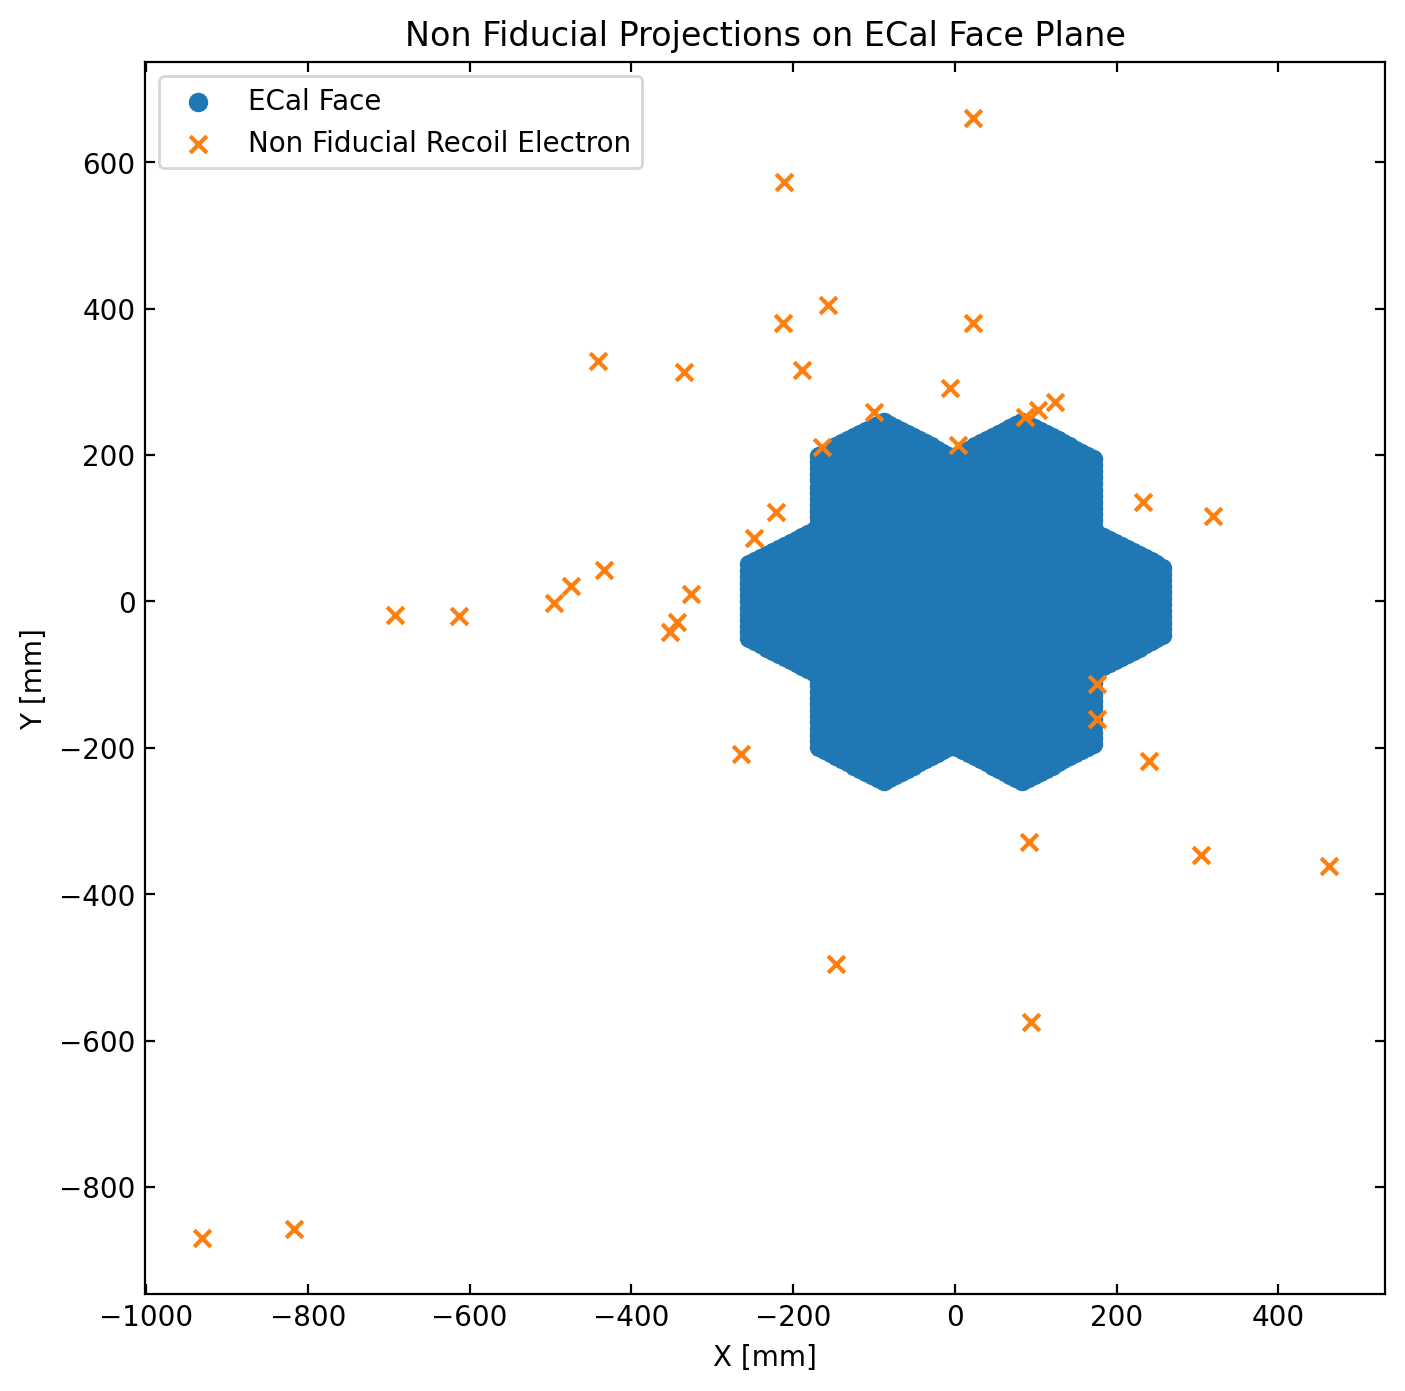

In [84]:
plt.figure(figsize=(8,8), dpi = 200)

positions1 = ecal_cells
positions2 = non_fid_map

x1, y1 = zip(*positions1)
x2, y2 = zip(*positions2)

plt.scatter(x1, y1, color='tab:blue', marker='o', label='ECal Face')
plt.scatter(x2, y2, color='tab:orange', marker='x', label='Non Fiducial Recoil Electron')

plt.tick_params(bottom=True,top=True,left=True,right=True,direction='in')
plt.title('Non Fiducial Projections on ECal Face Plane')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.legend()
plt.grid(False)
plt.show()


In [16]:
# # Open the ROOT file and load branches
# with uproot.open(file_path) as file:
#     tree = file["skimmed_events"]
#     recoilX = tree['recoilX_'].array(library='np')
#     recoilY = tree['recoilY_'].array(library='np')
#     recoilZ = tree['z_tsp_'].array(library='np')
#     recoilPx = tree['recoilPx_'].array(library='np')
#     recoilPy = tree['recoilPy_'].array(library='np')
#     recoilPz = tree['recoilPz_'].array(library='np')

In [33]:
# oncell = 0
# offcell = 0
# fid_events = []
# non_fid_events = []
# for index in range(0,len(f_cut)):
#     if f_cut[index] == 1:
#         oncell += 1
#         fid_events.append(index)
#     elif f_cut[index] == 0:
#         offcell += 1
#         non_fid_events.append(index)
# print('oncell: {}\noffcell: {}'.format(oncell,offcell))

In [34]:
# non_fid_events[10]

## test

In [28]:
tfile = r.TFile(filename)
ttree = tfile.Get('skimmed_events')

In [29]:
ttree.GetEntries() # total event number

18440

In [33]:
ttree.GetEntry(1)
ttree.Show()

======> EVENT:1
 passesVeto_     = 1
 nReadoutHits_   = 0
 summedDet_      = 0
 summedTightIso_ = 0
 discValue_      = 0.999975
 recoilX_        = -9999
 recoilY_        = -9999
 recoilPx_       = -9999
 recoilPy_       = -9999
 recoilPz_       = -9999
 pass_           = 1
 nSPHits         = 4
 nTSPHits        = 9
 nRecHits        = 0
 nHRecHits       = 0
 maxPE           = 0
 TargetSPRecoilE_pt = 5.38561
 pdgID_          = 22, 
                  22, 622, 622
 trackID_        = 14, 
                  14, 11, 11
 layerID_        = 0, 
                  0, 0, 0
 x_              = 231.45, 
                  440.341, -8.09162, -8.50476
 y_              = -150.494, 
                  -251.294, -10.2028, -10.5826
 z_              = 239.999, 
                  447.456, 239.999, 840
 px_             = 2.31003, 
                  2.31003, -5.50119, -5.50119
 py_             = -1.1147, 
                  -1.1147, -5.058, -5.058
 pz_             = 2.29417, 
                  2.29417, 7989.38, 798

In [31]:
pz_tsp_leaf = ttree.GetLeaf('pz_tsp_')
pdgID_tsp_leaf = ttree.GetLeaf('pdgID_tsp_')

In [34]:
pz_tsp_leaf.GetValue()

7996.6806640625

In [81]:
for i in range(0,pdgID_tsp_leaf.GetLen()):
    print(pdgID_tsp_leaf.GetValue(i))

11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
22.0
22.0
-11.0
-11.0
622.0
622.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
11.0
